# Flows for curtains

<img src="images/slides/curtains.png" width=200>

This notebook is a demonstration of how we can use flows to learn conditional distributions in high energy physics. 

This is read only for the time being. You will not be able to run anything.

In [1]:
# Imports
# A standard inn model
import numpy as np

import torch
import torch.optim as optim

from nflows import flows

from tensorboardX import SummaryWriter

from utils.training import fit

from models.flow_models import contextual_flow
from models.nn.flows import spline_flow
import nflows
from nflows.utils import torchutils

from utils import hyperparams
from utils.post_process import post_process_anode
from utils.io import get_top_dir

from data.data_loaders import get_data
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1638128)
np.random.seed(1638128)

# Hyper params from passed args
bsize = 100
n_epochs = 30
exp_name = 'RODEM_flows'

# Set up some saving paths and a writer
sv_dir = get_top_dir()
log_dir = sv_dir + '/logs/' + exp_name
writer = SummaryWriter(log_dir=log_dir)

We have data that is divided into 10 bins according to the mass of each object in the sample. Each bin/quantile has approximately the same number of samples.

In [3]:
# Make datasets
# The first list entry defines side band one, the second the signal region, the third side band two and the fourth is
# what we use as a validation region.
datasets = get_data('curtains', quantiles=[1, 2, 3, 4], flow=True)
ndata = datasets.ndata
inp_dim = datasets.nfeatures
print('There are {} training examples, {} validation examples and {} signal examples.'.format(
    datasets.trainset.data.shape[0], datasets.validationset.data.shape[0], datasets.signalset.data.shape[0]))

There are 19794 training examples, 9985 validation examples and 9953 signal examples.


We now have a training set ```datasets.trainset``` that contains all of the features plus the mass in the last row. This gives us four features to learn, plus the mass for conditioning.

In [6]:
print(datasets.trainset.data.shape)
print(datasets.trainset.data[:10])

torch.Size([19794, 5])
tensor([[-0.8229, -0.2165, -0.0522, -0.8938, -0.4301],
        [-0.5398,  0.0780, -0.1372, -0.9284, -0.5885],
        [-0.6960,  0.0974,  0.3163, -0.9552,  0.5244],
        [-0.2684, -0.6936,  0.0695, -0.7344, -0.9502],
        [-0.7795, -0.4043,  0.1174, -0.8931,  0.8532],
        [-0.8494, -0.3279,  0.3800, -0.9325,  0.3805],
        [-0.8223, -0.2468,  0.2992, -0.9480, -0.7311],
        [-0.7605,  0.0853,  0.0775, -0.9372,  0.8194],
        [-0.6705,  0.4177,  0.0816, -0.9399, -0.5864],
        [-0.8342, -0.0739, -0.0754, -0.9448,  0.4315]])


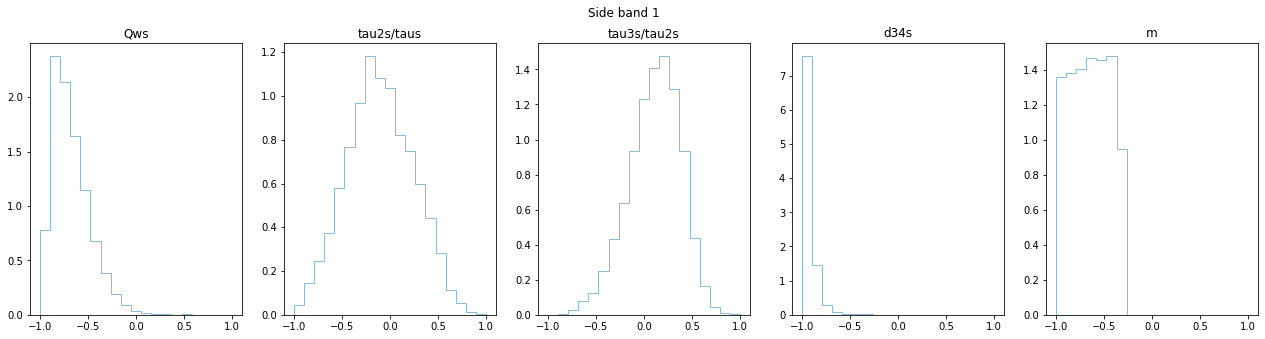

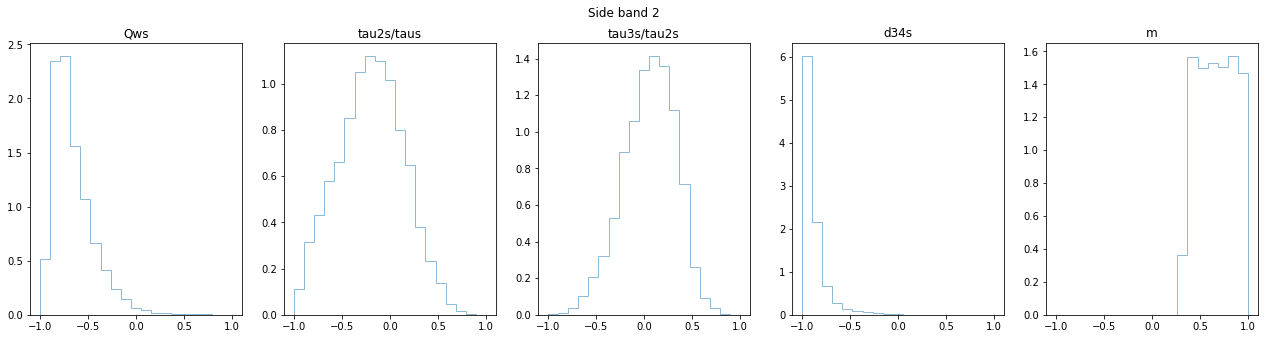

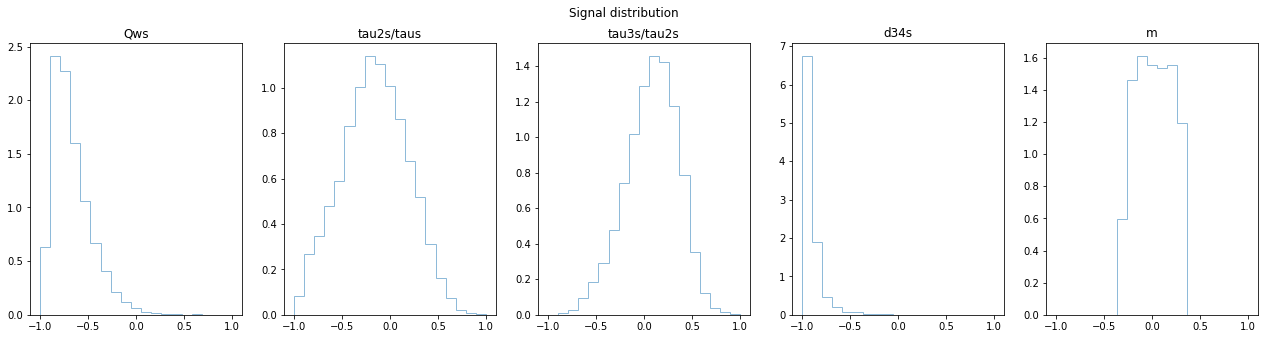

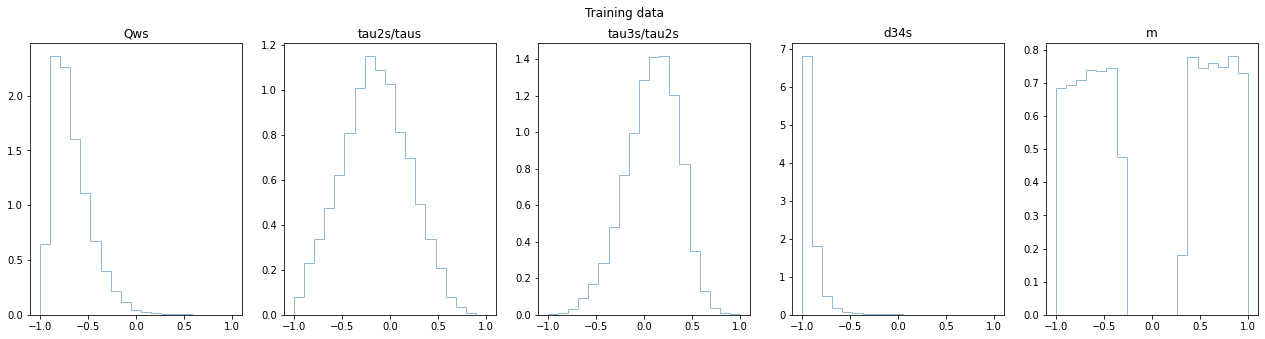

In [22]:
from utils.plotting import get_bins
def hist_features_single(data, feature_nms, bins, label='data'):
    fig, axs = plt.subplots(1, 5, figsize=(22, 5))
    data_dim = len(feature_nms)
    for i in range(data_dim):
        axs[i].hist(data[:, i].detach().cpu().numpy(), label=label, alpha=0.5, density=True, bins=bins,
                    histtype='step')
        axs[i].set_title(feature_nms[i])
    fig.suptitle(label)
    fig.show()

# Note: the data loader handles the data scaling.
bins = get_bins(datasets.trainset.data1.data)
hist_features_single(datasets.trainset.data1.data, datasets.feature_nms, bins, label='Side band 1')
hist_features_single(datasets.trainset.data2.data, datasets.feature_nms, bins, label='Side band 2')
hist_features_single(datasets.signalset.data, datasets.feature_nms, bins, label='Signal distribution')
hist_features_single(datasets.trainset.data.data, datasets.feature_nms, bins, label='Training data')

The block of data less than zero in this last plot is side band one, the block above zero is sideband two. The empty space in the middle is the signal region, where we would like to generate samples.

What we will now do is train a conditional flow on the data in the last plot. 

Each point in this mass distribution has four features plus the mass. 

Our goal: Learn the distribution of these features conditioned on their mass.

We will then test to see if the conditional flow we have trained generates samples that matches the distribution across features in the signal region.

In [6]:
# Set all tensors to be created on gpu, this must be done after dataset creation
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = torch.device('cpu')
print(device)

cpu


In [7]:
# Set up base transformation
tail_bound = 4.
tails = 'linear'
# Scale the data to be at the tail bounds
datasets.scale = tail_bound
datasets.scale_data()
# Take a normal distribution for the base
base_dist = nflows.distributions.StandardNormal([inp_dim])

In [8]:
# Build an autoregressive spline transformation 
# (coupling flows in fact work better, but this is cleaner for demonstration)
# We are going to condition on one feature - the mass
nodes = 20
nblocks = 3
nstack = 3
nbins = 10
# This is just a wrapper for building transformations in the exact same way that we have already seen.
transformation = spline_flow(inp_dim, nodes, num_blocks=nblocks, nstack=nstack, tail_bound=tail_bound,
                             tails=tails, activation=hyperparams.activations['leaky_relu'], num_bins=nbins,
                             context_features=1)
# Build a flow
flow = flows.Flow(transformation, base_dist)

# Build a meta model - a context flow that we can train with our custom fit method
flow_model = contextual_flow(flow, base_dist, device, exp_name, dir='NSF_CURTAINS')

In [9]:
# Define optimizers and learning rate schedulers
optimizer = optim.Adam(flow.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, ndata / bsize * n_epochs, 0)

# This is an outline of how the flow is trained
training_data = torch.utils.data.DataLoader(datasets.trainset, batch_size=bsize, shuffle=True)
for epoch in range(n_epochs):

    running_loss = 0.0
    for i, data in enumerate(training_data, 0):

        # zero the parameter gradients
        optimizer.zero_grad()

        # And the second change is here, where we pass a context to our flow
        # Note: the label must be reshaped to be used as context
        loss = -flow.log_prob(data[:, :-1], context=data[:, -1].view(-1, 1)).mean()
        loss.backward()
        optimizer.step()

# In reality this is the method that we use
# Gradient clipping is useful for training these models
# fit(flow_model, optimizer, datasets.trainset, n_epochs, bsize, writer, schedulers=scheduler, gclip=5)

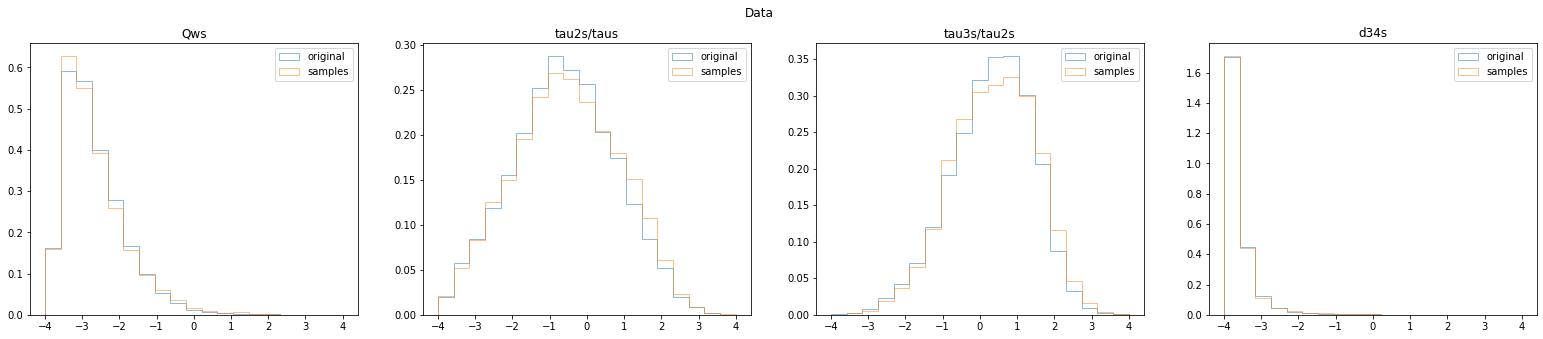

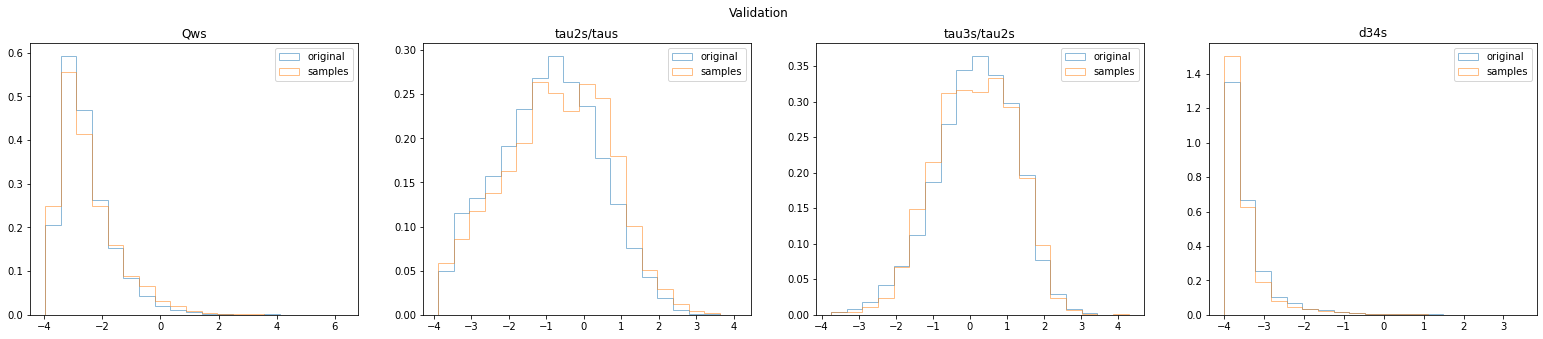

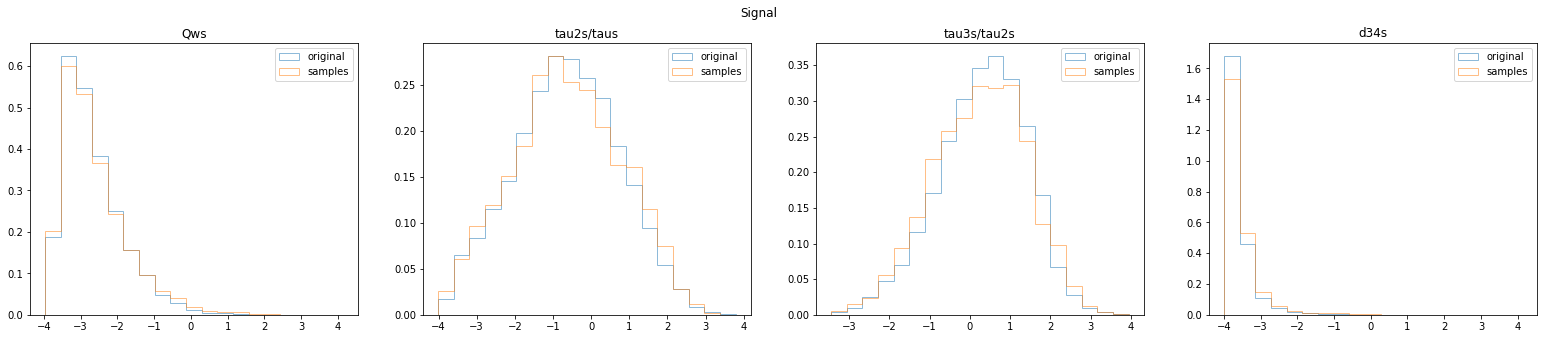

In [10]:
from utils.plotting import hist_features

nfeatures = datasets.nfeatures

def hist_dataset(dataset, sv_name, nms):
    context_valid = dataset.data[:, -1].view(-1, 1).to(device)
    data_valid = dataset.data[:, :-1]

    with torch.no_grad():
        valid_samples = flow.sample(1, context_valid).squeeze()

    ncols = int(np.ceil(nfeatures / 4))
    fig, axs_ = plt.subplots(ncols, 4, figsize=(5 * 5 + 2, 5 * ncols))
    axs = fig.axes
    hist_features(data_valid, valid_samples, flow_model, nfeatures, axs, nms)
    fig.suptitle(sv_name)
    fig.show()

hist_dataset(datasets.trainset, 'Data', datasets.feature_nms)
hist_dataset(datasets.validationset, 'Validation', datasets.feature_nms)
hist_dataset(datasets.signalset, 'Signal', datasets.feature_nms)

In [11]:
# We can also calculate the number of outliers in each bin using a cut on the likelihood of the training data
# Note: We should have a separate validation set within each of our bins for this.
def get_outlier_sample(dataset, mult_sampl=1, threshold=0.95, set_cut=None):
    context = dataset.data[:, -1].view(-1, 1).to(device)
    with torch.no_grad():
        samples = flow.sample(mult_sampl, context).squeeze()
        lp = flow.log_prob(samples, context=context)
        if set_cut is None:
            cut = torch.quantile(lp, 1 - threshold)
        else:
            cut = set_cut
        outliers = samples[:, -1][lp < cut]

    if set_cut is None:
        return outliers, cut
    else:
        return outliers

threshold = 0.95
data_outlier_context, cut = get_outlier_sample(datasets.trainset, threshold=0.95)
valid_outlier_context = get_outlier_sample(datasets.validationset, set_cut=cut)
sample_outlier_context = get_outlier_sample(datasets.signalset, set_cut=cut)
print(
    'There are {:.4}% samples in the validation set, and {:.4}% outliers in the signal region. \n'
    'There are {:.4}% in the training data.'.format(
        len(valid_outlier_context) / len(datasets.validationset) * 100,
        len(sample_outlier_context) / len(datasets.signalset) * 100,
    (1 - threshold) * 100))

There are 6.72% samples in the validation set, and 6.149% outliers in the signal region. 
There are 5.0% in the training data.
